# INF659-PUCP-2022-02 - Rayos X - Neumonía

## Experimentación con data augmentation + fine tuning
Competencia para el Curso de Técnicas Avanzadas de Data Mining y Sistemas Inteligentes 2022-02

- Alumno: Alipio Laboriano Galindo 

**Descripción**. Este desafío consiste en predecir que personas tienen neumonía. El dataset contiene imágenes de Rayos X del Tórax de pacientes que han sido diagnosticadas con neumonía severa y de pacientes que no han tenido neumonía severa después de un análisis por un médico experto. Por ello, se debe entrenar un modelo que tome como entrada una imagen de Rayos X del Tórax y determine si en la imagen hay o no neumonía.

In [ ]:
# Cargar librerías
from google.colab import drive 
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import  InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tqdm import tqdm
from random import choice
%matplotlib inline


import pandas as pd
import seaborn as sns
from sklearn.metrics import *
import os

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Oct 13 03:58:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Conectarse a drive
drive.mount("/drive")

Mounted at /drive


In [ ]:
## Establecer directorio de trabajo
%cd "/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia"

/drive/MyDrive/Maestria/Ciclo2/TADMSI/RayosX_Neumonia


## 1. Cargar imágenes

In [ ]:
# Configurar parámetros
images_train = 'images/train' # Ruta con imágenes de entrenamiento
validation_split = 0.20 # 20% para el conjunto de validación y 80% para entrenamiento
img_size = 224  # Redimensionar la imágenes
batch_size = 32 # Tamaño de lote para entrenar
seed = 50 # Semilla aleatoria para reproducir los experimentos.

In [ ]:
# Función para importar el método de preprocesamiento.
def select_preprocess_input(applications):
    # Como cada aplicación de Keras espera un tipo específico de preprocesamiento de entrada, 
    # importamos el procesamiento dependiendo del modelo utilizado
    if applications == 'ResNet50':
        from tensorflow.keras.applications.resnet50 import preprocess_input # Convierte las imágenes de entrada de RGB a BGR, luego centrará en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar.
    elif applications == 'ResNet152V2':
        from tensorflow.keras.applications.resnet_v2 import preprocess_input # escalará los píxeles de entrada entre -1 y 1.
    elif applications == 'VGG16':
        from tensorflow.keras.applications.vgg16 import preprocess_input #convertirá las imágenes de entrada de RGB a BGR, luego centrará en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar.
    elif applications == 'VGG19':
        from tensorflow.keras.applications.vgg19 import preprocess_input #convertirá las imágenes de entrada de RGB a BGR, luego centrará en cero cada canal de color con respecto al conjunto de datos de ImageNet, sin escalar.
    elif applications == 'InceptionV3':
        from tensorflow.keras.applications.inception_v3 import  preprocess_input # escalará los píxeles de entrada entre -1 y 1.
    elif applications == 'InceptionResNetV2':
        from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input # escalará los píxeles de entrada entre -1 y 1.
    return preprocess_input

In [ ]:
# Función para construir dataset.
def images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed):
    # Importar preprocess input function
    preprocess_input = select_preprocess_input(applications)

    ##Especificamos la función de preprocesamiento o el generador de dataset 80% entrenamiento, 20% validación
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                       
                                   rotation_range = 40, # Angulo de rotación de la imágen
                                   width_shift_range = 0.2, # 20% del ancho de la imagen total.
                                   height_shift_range = 0.2, # 20% de la altura de la imagen.                              
                                   horizontal_flip=True,

                                   validation_split=validation_split)
    
    # Construimos el dataset de entrenamiento
    train_generator = train_datagen.flow_from_directory(images_train, # Directorio de la imágenes de entrenamiento
                                                    target_size=(img_size, img_size), # Tamaño al cual se redimensionará las imágenes
                                                    shuffle=True, # Desordenar la imágnes
                                                    color_mode="rgb", # Imágenes a color
                                                    class_mode="sparse", 
                                                    batch_size=batch_size, 
                                                    subset="training",
                                                    #weights="imagenet",
                                                    seed = seed)
    
    # Construir dataset de validación.
    validation_generator = train_datagen.flow_from_directory(images_train, 
                                                         target_size=(img_size, img_size),
                                                         shuffle=False, ### Ojo que pasa si cambiar a True
                                                         color_mode="rgb",
                                                         class_mode="sparse", 
                                                         batch_size=batch_size, 
                                                         subset="validation",
                                                         #weights="imagenet",
                                                         seed=seed)
    target_train = np.bincount(train_generator.labels)/len(train_generator.labels)
    target_valid = np.bincount(validation_generator.labels)/len(validation_generator.labels)

    return train_generator, validation_generator, target_train, target_valid


In [ ]:
# Plotear imagenes al azar
def plot_random_image(path, list_of_images_paths):
  #Seleccionar aleatoriamente una imagen
  random_image_path = choice(list_of_images_paths)

  #Cargar la imagen
  image = Image.open(path + "/" + random_image_path).convert("RGBA")

  #Mostrar la imagen
  plt.imshow(image)
  plt.axis("off")

In [ ]:
# Función para mostrar las curvas de rendimiento.
def show_results(log):
  loss = log.history['loss']
  acc = log.history['accuracy']

  val_loss = log.history['val_loss']
  val_acc = log.history['val_accuracy']
  
  fig, axes = plt.subplots(1, 2, figsize=(14,4))
  ax1, ax2 = axes

  ax1.plot(loss, label='train')
  ax1.plot(val_loss, 'o--', label='test')
  
  ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
  
  ax2.plot(acc, label='train')
  ax2.plot(val_acc, 'o--', label='test')
  
  ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
  
  for ax in axes: ax.legend()

In [ ]:
# Función para clasificar imagen por imagen
def get_class(path, random_image_path, labels_dict, final_model, applications):
    # Importar preprocess input function
    preprocess_input = select_preprocess_input(applications)
    #Cargar la imagen del path
    img = Image.open(path + "/" + random_image_path).convert("RGB")
    
    #Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    
    #Cambiar el tamaño de la imagen
    img_resized = img.resize((224, 224))

    #Cambiar a formato numpy
    x = np.asarray(img_resized, np.float32)
    x = x[None] #(224, 224, 3) -> (1, 224, 224, 3)
    
    #Preprocesamos la imagen
    x = preprocess_input(x)
    
    #Obtener la predicción
    y = final_model.predict(x)
    
    #Decodificar la predicción
    pred = labels_dict[np.argmax(y)]
    
    real = random_image_path.split("/", 1)[0]
    
    plt.title(f"Real value = {real} - Model prediction = {pred}")
    plt.show()

In [ ]:
def predict_new_dataset(path_model, dataset, applications, subset = 'test'):
    """Si subset = test, se da como argumento de dataset la ruta de las imágenes a predecir.
    Si subset != de test, se da como argumento de dataset el datset genrado anteriormente validation_generator"""
    #basado en: https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

    # Leer el modelo entrenado
    trained_model = tf.keras.models.load_model(path_model) 
    # Importar preprocess input function
    preprocess_input = select_preprocess_input(applications)
    # Configurar parámetros
    if subset=='test':
        img_size = 224
        batch_size = 1

        #Especificamos la función de preprocesamiento o el generador de dataset
        test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

        # Construimos el dataset a escorear
        test_generator = test_datagen.flow_from_directory(dataset, # Directorio de la imágenes de entrenamiento
                                                            target_size=(img_size, img_size), # Tamaño al cual se redimensionará las imágenes
                                                            shuffle=False, # Desordenar la imágnes
                                                            color_mode="rgb", # Imágenes a color
                                                            class_mode=None,
                                                            batch_size=batch_size)
        #Obtener la predicción
        STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
        test_generator.reset()
        y=trained_model.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)[:,1]

        labels = (test_generator.class_indices)
        filenames=test_generator.filenames
    else:
        y = trained_model.predict(dataset,  verbose=1)[:,1]
        labels = (dataset.class_indices)
        filenames=dataset.filenames

    
    output=pd.DataFrame({"Filename":filenames,
                        "Predictions":y})
    return output


In [ ]:
# Graficar curva ROC
# Basado en https://www.delftstack.com/es/howto/python/plot-roc-curve-python/#:~:text=Definici%C3%B3n%20de%20curva%20ROC%20en%20Python,-El%20t%C3%A9rmino%20curva&text=Esta%20curva%20es%20b%C3%A1sicamente%20una,real%2C%20es%20decir%2C%20la%20verdadera

def plot_roc_curve(fper, tper, auc, applications):

    plt.figure(figsize=(9,6))
    plt.plot(fper, tper, color='blue', label='ROC:' + str(round(auc,5)))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve {}'.format(applications))
    plt.legend()
    plt.show()

In [ ]:
def plot_matriz_confusion(dataset, df_pred, applications):
    cf_matrix = confusion_matrix(dataset.labels, df_pred.pred)
    print('Total de pacientes: ', cf_matrix.sum())
    # Plotear matriz de confusción
    ax = sns.heatmap(cf_matrix.astype(int), annot=True, cmap='Blues',  fmt='g')

    ax.set_title('Distribución de pacientes, con neumonía? - {}\n'.format(applications));
    ax.set_xlabel('\nValores predichos')
    ax.set_ylabel('Valores actuales ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['No','Si'])
    ax.yaxis.set_ticklabels(['No','Si'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
# Función para editar envíos
#!mkdir envios2
def edit_submission_data(df_submission, applications):
    print(applications)
    # Extraer Filename de la imagen.
    File_names = []
    for file in df_submission.Filename:
        File_names.append(file.split('/')[1])
    df_submission['File_names'] = File_names

    # leer data de test.
    df_test = pd.read_csv('data/test_x.csv')
    print(df_submission.shape, df_test.shape)

    # Eliminar columna no requerida
    df_submission = df_submission.drop('Filename',axis = 1)

    # unir dataseta
    df_submission = df_submission.merge(df_test, on = 'File_names', how = 'left')
    # Comprobar que no haya nas
    print('Total de valores nulos: ', df_submission.isna().sum().sum())
    # Otdenar df por ID
    df_submission = df_submission[['Id', 'Predictions','File_names']].sort_values('Id')
    # Editar columnas
    df_submission = df_submission[['Id', 'Predictions']].sort_values('Id')
    df_submission.columns = ['Id', 'Predicted']
    # Guardar data
    df_submission.to_csv('envios2/submission1_{}.csv'.format(applications), index = False)
    return df_submission

## 2. Experimentación - Definir los modelos

### 2.1 ResNet50

In [ ]:
%%time
# Generar dataset de entrenamiento y validación.
applications = 'ResNet50'
train_generator, validation_generator, target_train, target_valid = images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed)

Found 3982 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
CPU times: user 180 ms, sys: 18.7 ms, total: 198 ms
Wall time: 419 ms


In [ ]:
target_train, target_valid

(array([0.27021597, 0.72978403]), array([0.27035176, 0.72964824]))

In [ ]:
# Modelo base ResNet, para extracción de características
base_model = ResNet50(include_top=False, # Eliminar las últimas capas densas de ResNet y quedarse solamente con las capas de feature extraction
                      input_shape=(img_size, img_size, 3), # Configurada para imágen a colores
                      pooling="avg")
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Modelo para la predicción de clases - customizado - fine tuning?
model = Sequential()
model.add(Dense(128, input_shape=(2048,), activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 2)                 258       
                                                                 
Total params: 262,530
Trainable params: 262,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Conectamos la extracción de características mediante ResNet y la nuestra red densa
final_model = Sequential()
final_model.add(base_model)
final_model.add(model)

final_model.compile(optimizer=Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential_2 (Sequential)   (None, 2)                 262530    
                                                                 
Total params: 23,850,242
Trainable params: 262,530
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
if 'working2' not in os.listdir():
    os.mkdir('working2')
print(applications)

ResNet50


In [ ]:
# Early stopping & checkpointing the best model in ../working2 dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = 'working2/best_{}_da_ft.hdf5'.format(applications), monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [ ]:
%%time
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/100
63/63 [==============================] - 120s 2s/step - loss: 0.4657 - accuracy: 0.8021 - val_loss: 0.2224 - val_accuracy: 0.9146
Epoch 2/100
63/63 [==============================] - 108s 2s/step - loss: 0.2423 - accuracy: 0.9001 - val_loss: 0.2069 - val_accuracy: 0.9196
Epoch 3/100
63/63 [==============================] - 108s 2s/step - loss: 0.2107 - accuracy: 0.9161 - val_loss: 0.1820 - val_accuracy: 0.9407
Epoch 4/100
63/63 [==============================] - 107s 2s/step - loss: 0.1954 - accuracy: 0.9257 - val_loss: 0.1691 - val_accuracy: 0.9397
Epoch 5/100
63/63 [==============================] - 106s 2s/step - loss: 0.1896 - accuracy: 0.9262 - val_loss: 0.1743 - val_accuracy: 0.9437
Epoch 6/100
63/63 [==============================] - 107s 2s/step - loss: 0.1782 - accuracy: 0.9309 - val_loss: 0.1527 - val_accuracy: 0.9477
Epoch 7/100
63/63 [==============================] - 106s 2s/step - loss: 0.1652 - accuracy: 0.9387 - val_loss: 0.1530 - val_accuracy: 0.9558
Epoch 

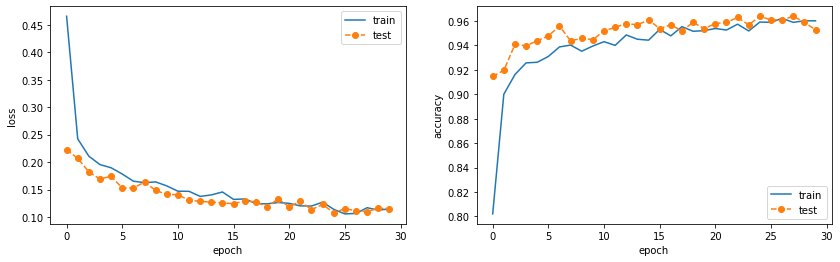

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Fine Tuning

In [ ]:
# Descongelar las capas de extracción de características
base_model.trainable = True

In [ ]:
# Veamos cuántas capas hay en el modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune a partir de estas capas
fine_tune_at = 50

# Congelar todas las capas más inferiores en este caso desde la 0:100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  176


In [ ]:
#Como está entrenando un modelo mucho más grande y quiere readaptar los pesos preentrenados,
#  es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, el modelo podría sobreajustarse muy rápidamente.

final_model.compile(optimizer=Adam(0.0001/10), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 sequential_2 (Sequential)   (None, 2)                 262530    
                                                                 
Total params: 23,850,242
Trainable params: 23,189,634
Non-trainable params: 660,608
_________________________________________________________________


In [ ]:
len(final_model.trainable_variables)

156

In [ ]:
# Continúe entrenando el modelo
# Si ha entrenado antes hasta la convergencia, este paso mejorará su precisión en algunos puntos porcentuales.
initial_epochs = 100
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=total_epochs,
                      initial_epoch=log.epoch[-1],
                      callbacks=[cb_checkpointer, cb_early_stopper])


Epoch 30/110
63/63 [==============================] - 124s 2s/step - loss: 0.1768 - accuracy: 0.9304 - val_loss: 0.1362 - val_accuracy: 0.9528
Epoch 31/110
63/63 [==============================] - 110s 2s/step - loss: 0.1301 - accuracy: 0.9568 - val_loss: 0.1115 - val_accuracy: 0.9618
Epoch 32/110
63/63 [==============================] - 110s 2s/step - loss: 0.1135 - accuracy: 0.9543 - val_loss: 0.1110 - val_accuracy: 0.9568
Epoch 33/110
63/63 [==============================] - 113s 2s/step - loss: 0.1019 - accuracy: 0.9638 - val_loss: 0.0954 - val_accuracy: 0.9709
Epoch 34/110
63/63 [==============================] - 121s 2s/step - loss: 0.0836 - accuracy: 0.9704 - val_loss: 0.0939 - val_accuracy: 0.9739
Epoch 35/110
63/63 [==============================] - 124s 2s/step - loss: 0.0836 - accuracy: 0.9689 - val_loss: 0.0848 - val_accuracy: 0.9729
Epoch 36/110
63/63 [==============================] - 125s 2s/step - loss: 0.0708 - accuracy: 0.9764 - val_loss: 0.0822 - val_accuracy: 0.9698

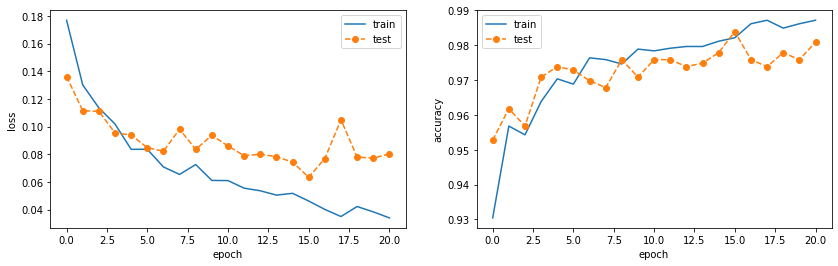

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Probando el modelo

In [ ]:
print(applications)

ResNet50


In [ ]:
labels_dict = {k: i for i, k in validation_generator.class_indices.items()}

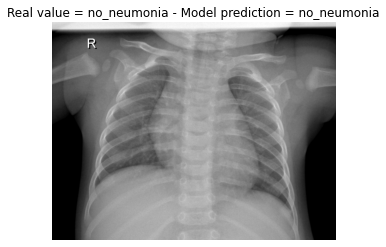

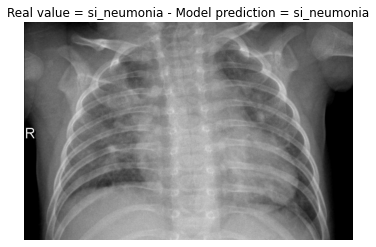

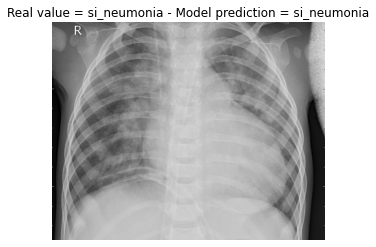

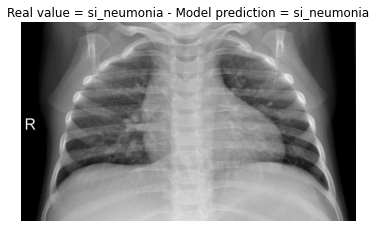

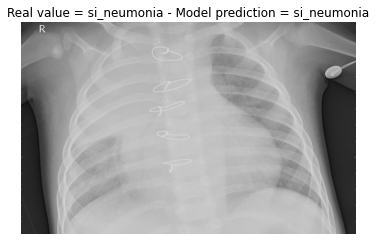

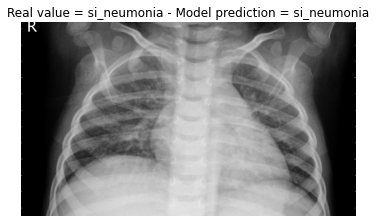

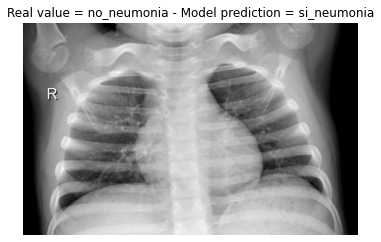

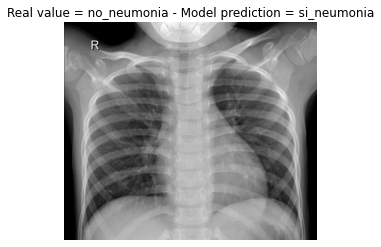

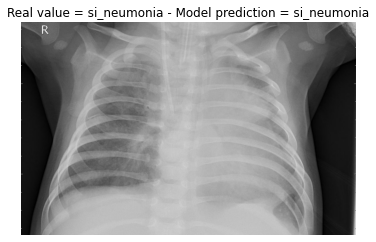

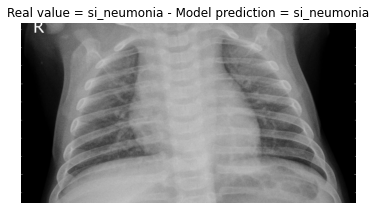

In [ ]:
number_of_images_to_test = 10

for _ in range(number_of_images_to_test):
  random_image_path = choice(validation_generator.filenames)
  
  get_class(images_train, random_image_path, labels_dict, final_model, applications)

## Predecir en data de validación


In [ ]:
print(applications)

ResNet50


In [ ]:
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
path_model = 'working2/best_{}_da_ft.hdf5'.format(applications)  
dataset= validation_generator
df_val = predict_new_dataset(path_model, dataset, applications, subset = 'valid')
df_val.shape

16/16 [==============================] - 22s 1s/step


(995, 2)

In [ ]:
# Punto de corte para predecir 0 ó 1 y ver otras métricas
cut_point = df_val.Predictions.mean()
print(1-cut_point)
# Crear columna con predicción
df_val['pred'] = np.where(df_val.Predictions>1-cut_point,1,0)
df_val.head()

0.2777784466743469


,Filename,Predictions,pred
0,no_neumonia/004f7319-a006-5476-bba3-5a12c8a0f0...,0.002005,0
1,no_neumonia/00880387-7447-5ec2-a87d-deb294cfb3...,0.016786,0
2,no_neumonia/00af7693-5b69-528a-8e2b-bd99fed024...,0.000448,0
3,no_neumonia/00b1ea4d-3701-5eb9-928b-e22545be06...,0.000266,0
4,no_neumonia/00e2b542-2920-5728-bcd8-d16cf45a22...,0.019643,0


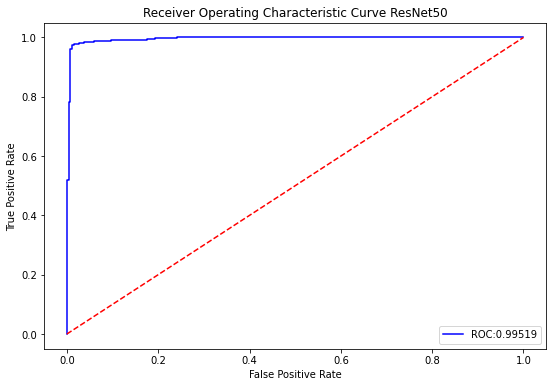

In [ ]:
# Plotear curva roc
auc = roc_auc_score (validation_generator.labels, df_val.Predictions) 
fper, tper, thresholds = roc_curve(validation_generator.labels, df_val.Predictions)
plot_roc_curve(fper, tper, auc, applications)

In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       269
           1       0.98      0.98      0.98       726

    accuracy                           0.98       995
   macro avg       0.97      0.97      0.97       995
weighted avg       0.98      0.98      0.98       995



Total de pacientes:  995


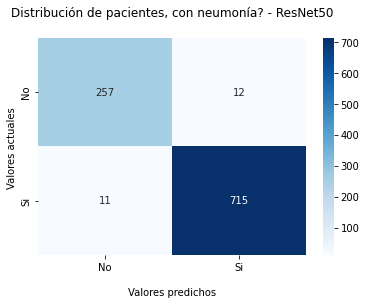

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

### Predecir data de test

In [ ]:
print(applications)

ResNet50


In [ ]:
path_model = 'working2/best_{}_da_ft.hdf5'.format(applications)
print(path_model)
dataset= 'images/test'
#predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1 = predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1.head()

working2/best_ResNet50_da_ft.hdf5
Found 879 images belonging to 1 classes.
879/879 [==============================] - 34s 38ms/step


,Filename,Predictions
0,test_images/00182334-9ad9-516c-b0e4-10a316c61e...,0.998316
1,test_images/005030d9-7ee8-5082-ad72-1d9929d06e...,0.991160
2,test_images/00a0a69c-f14c-5f11-85ca-0f2e6729c3...,0.999499
3,test_images/00e84c18-3a08-59a8-9e3b-ed706c01e8...,0.000012
4,test_images/0158ac33-e4b2-5cd4-85de-0655c23cb9...,0.999420


In [ ]:
# Generar data y editar para envío
df_submission = edit_submission_data(submission1, applications)
df_submission.head()

ResNet50
(879, 3) (879, 2)
Total de valores nulos:  0


,Id,Predicted
90,0,0.997996
698,1,0.572275
399,2,0.000376
422,3,0.999948
305,4,0.999998


## 2.2. ResNet152V2

In [ ]:
# Configurar parámetros
images_train = 'images/train' # Ruta con imágenes de entrenamiento
validation_split = 0.2 # 20% para el conjunto de validación y 80% para entrenamiento
img_size = 224*2  # Redimensionar la imágenes
batch_size = 32 # Tamaño de lote para entrenar
seed = 50 # Semilla aleatoria para reproducir los experimentos.

In [ ]:
%%time
# Generar dataset de entrenamiento y validación.
applications = 'ResNet152V2'
train_generator, validation_generator, target_train, target_valid = images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed)

Found 3982 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
CPU times: user 203 ms, sys: 33.5 ms, total: 236 ms
Wall time: 827 ms


In [ ]:

target_train, target_valid

(array([0.27021597, 0.72978403]), array([0.27035176, 0.72964824]))

In [ ]:
# Modelo base ResNet, para extracción de características
base_model = ResNet152V2(include_top=False, # Eliminar las últimas capas densas de ResNet y quedarse solamente con las capas de feature extraction
                      input_shape=(img_size, img_size, 3), # Configurada para imágen a colores
                      pooling="avg")
base_model.trainable = False
base_model.summary()

234561536/234545216 [==============================] - 1s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 454, 454, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 224, 224, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                     

In [ ]:
# Modelo para la predicción de clases - customizado
model = Sequential()
model.add(Dense(128, input_shape=(2048,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 262,530
Trainable params: 262,530
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Conectamos la extracción de características mediante ResNet y la nuestra red densa
final_model = Sequential()
final_model.add(base_model)
final_model.add(model)

final_model.compile(optimizer=Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 sequential (Sequential)     (None, 2)                 262530    
                                                                 
Total params: 58,594,178
Trainable params: 262,530
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
if 'working2' not in os.listdir():
    os.mkdir('working2')

# Early stopping & checkpointing the best model in ../working2 dir & restoring that as our model for prediction
print(applications)
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = 'working2/best_{}.hdf5'.format(applications), monitor = 'val_loss', save_best_only = True, mode = 'auto')

ResNet152V2


In [ ]:
%%time
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/100
125/125 [==============================] - 1160s 9s/step - loss: 0.3267 - accuracy: 0.8719 - val_loss: 0.2319 - val_accuracy: 0.9146
Epoch 2/100
125/125 [==============================] - 271s 2s/step - loss: 0.2085 - accuracy: 0.9181 - val_loss: 0.1775 - val_accuracy: 0.9367
Epoch 3/100
125/125 [==============================] - 270s 2s/step - loss: 0.1695 - accuracy: 0.9382 - val_loss: 0.1728 - val_accuracy: 0.9367
Epoch 4/100
125/125 [==============================] - 270s 2s/step - loss: 0.1609 - accuracy: 0.9375 - val_loss: 0.1727 - val_accuracy: 0.9397
Epoch 5/100
125/125 [==============================] - 269s 2s/step - loss: 0.1457 - accuracy: 0.9468 - val_loss: 0.1526 - val_accuracy: 0.9427
Epoch 6/100
125/125 [==============================] - 271s 2s/step - loss: 0.1422 - accuracy: 0.9478 - val_loss: 0.1616 - val_accuracy: 0.9417
Epoch 7/100
125/125 [==============================] - 272s 2s/step - loss: 0.1359 - accuracy: 0.9508 - val_loss: 0.1391 - val_accuracy

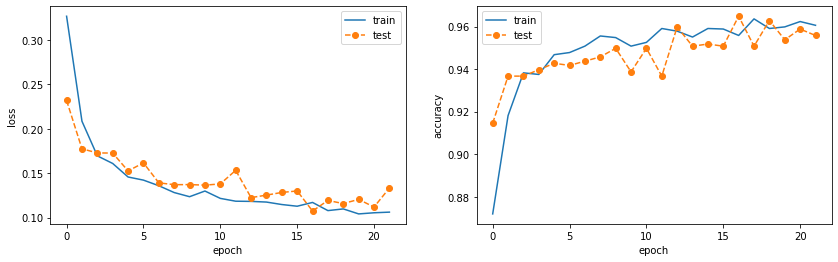

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Fine tuning

In [ ]:
# Descongelar las capas de extracción de características
base_model.trainable = True

In [ ]:
# Veamos cuántas capas hay en el modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune a partir de estas capas
fine_tune_at = 400

# Congelar todas las capas más inferiores en este caso desde la 0:100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  565


In [ ]:
#Como está entrenando un modelo mucho más grande y quiere readaptar los pesos preentrenados,
#  es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, el modelo podría sobreajustarse muy rápidamente.

final_model.compile(optimizer=Adam(0.0001/10), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

len(final_model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 2048)              58331648  
                                                                 
 sequential (Sequential)     (None, 2)                 262530    
                                                                 
Total params: 58,594,178
Trainable params: 28,387,202
Non-trainable params: 30,206,976
_________________________________________________________________


153

In [ ]:
# Continúe entrenando el modelo
# Si ha entrenado antes hasta la convergencia, este paso mejorará su precisión en algunos puntos porcentuales.
#initial_epochs = 100
#fine_tune_epochs = 10
#total_epochs =  initial_epochs + fine_tune_epochs

In [ ]:
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      initial_epoch=log.epoch[-5],
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 18/100
125/125 [==============================] - 315s 2s/step - loss: 0.1705 - accuracy: 0.9319 - val_loss: 0.1244 - val_accuracy: 0.9628
Epoch 19/100
125/125 [==============================] - 298s 2s/step - loss: 0.1237 - accuracy: 0.9535 - val_loss: 0.0834 - val_accuracy: 0.9668
Epoch 20/100
125/125 [==============================] - 297s 2s/step - loss: 0.1057 - accuracy: 0.9606 - val_loss: 0.0930 - val_accuracy: 0.9678
Epoch 21/100
125/125 [==============================] - 299s 2s/step - loss: 0.0910 - accuracy: 0.9674 - val_loss: 0.0830 - val_accuracy: 0.9739
Epoch 22/100
125/125 [==============================] - 299s 2s/step - loss: 0.0807 - accuracy: 0.9739 - val_loss: 0.0823 - val_accuracy: 0.9688
Epoch 23/100
125/125 [==============================] - 299s 2s/step - loss: 0.0674 - accuracy: 0.9764 - val_loss: 0.0815 - val_accuracy: 0.9688
Epoch 24/100
125/125 [==============================] - 299s 2s/step - loss: 0.0649 - accuracy: 0.9764 - val_loss: 0.0746 - val_ac

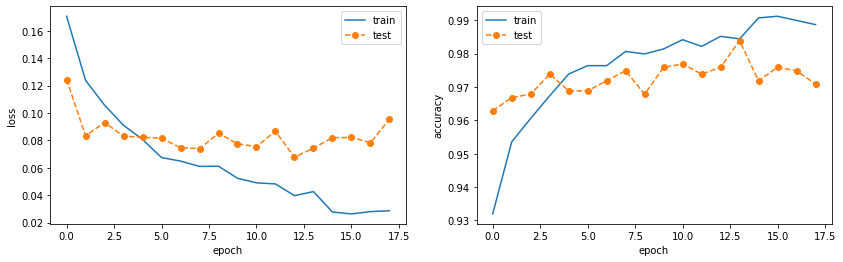

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Probando el modelo

### Predecir en data de validación

In [ ]:
print(applications)

ResNet152V2


In [ ]:
print(applications)
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
path_model = 'working2/best_{}.hdf5'.format(applications)
dataset= validation_generator
df_val = predict_new_dataset(path_model, dataset, applications, subset = 'valid')
df_val.shape

ResNet152V2
32/32 [==============================] - 58s 2s/step


(995, 2)

In [ ]:
# Punto de corte para predecir 0 ó 1 y ver otras métricas
cut_point = df_val.Predictions.mean()
print(1-cut_point)
# Crear columna con predicción
df_val['pred'] = np.where(df_val.Predictions>1-cut_point,1,0)
df_val.head()

0.27496248483657837


,Filename,Predictions,pred
0,no_neumonia/004f7319-a006-5476-bba3-5a12c8a0f0...,0.005101,0
1,no_neumonia/00880387-7447-5ec2-a87d-deb294cfb3...,0.047676,0
2,no_neumonia/00af7693-5b69-528a-8e2b-bd99fed024...,0.001881,0
3,no_neumonia/00b1ea4d-3701-5eb9-928b-e22545be06...,0.020878,0
4,no_neumonia/00e2b542-2920-5728-bcd8-d16cf45a22...,0.007871,0


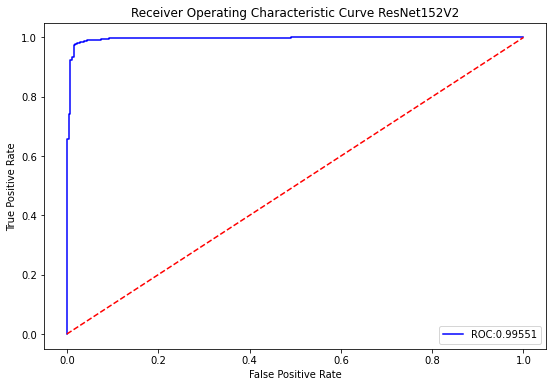

In [ ]:
# Plotear curva roc
auc = roc_auc_score (validation_generator.labels, df_val.Predictions) 
fper, tper, thresholds = roc_curve(validation_generator.labels, df_val.Predictions)
plot_roc_curve(fper, tper, auc, applications)

In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       269
           1       0.98      0.99      0.99       726

    accuracy                           0.98       995
   macro avg       0.98      0.97      0.97       995
weighted avg       0.98      0.98      0.98       995



Total de pacientes:  995


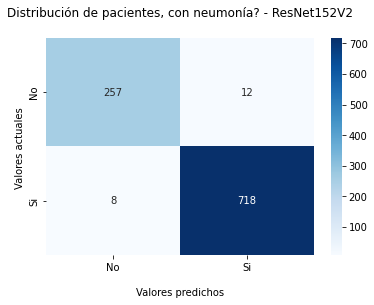

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

### Predecir data de test

In [ ]:
print(applications)
path_model = 'working2/best_{}.hdf5'.format(applications)
print(path_model)
dataset= 'images/test'
#predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1 = predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1.head()

ResNet152V2
working2/best_ResNet152V2.hdf5
Found 879 images belonging to 1 classes.
879/879 [==============================] - 36s 36ms/step


,Filename,Predictions
0,test_images/00182334-9ad9-516c-b0e4-10a316c61e...,1.000000
1,test_images/005030d9-7ee8-5082-ad72-1d9929d06e...,0.959655
2,test_images/00a0a69c-f14c-5f11-85ca-0f2e6729c3...,0.372133
3,test_images/00e84c18-3a08-59a8-9e3b-ed706c01e8...,0.001952
4,test_images/0158ac33-e4b2-5cd4-85de-0655c23cb9...,0.999738


In [ ]:
# Generar data y editar para envío
print(applications)
df_submission = edit_submission_data(submission1, applications)
df_submission.head()

ResNet152V2
ResNet152V2
(879, 3) (879, 2)
Total de valores nulos:  0


,Id,Predicted
90,0,0.993077
698,1,0.003919
399,2,0.000075
422,3,0.999988
305,4,1.000000


### 2.3 VGG16

In [ ]:
%%time
# Generar dataset de entrenamiento y validación.
applications = 'VGG16'
train_generator, validation_generator, target_train, target_valid = images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed)

Found 3982 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
CPU times: user 240 ms, sys: 27.4 ms, total: 267 ms
Wall time: 21.6 s


In [ ]:
target_train, target_valid

(array([0.27021597, 0.72978403]), array([0.27035176, 0.72964824]))

In [ ]:
# Modelo base ResNet, para extracción de características
base_model = VGG16(include_top=False, # Eliminar las últimas capas densas de ResNet y quedarse solamente con las capas de feature extraction
                      input_shape=(img_size, img_size, 3), # Configurada para imágen a colores
                      pooling="avg")
base_model.trainable = False
base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Modelo para la predicción de clases - customizado - fine tuning?
model = Sequential()
model.add(Dense(128, input_shape=(512,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 65,922
Trainable params: 65,922
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Conectamos la extracción de características mediante ResNet y la nuestra red densa
final_model = Sequential()
final_model.add(base_model)
final_model.add(model)

final_model.compile(optimizer=Adam(0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 65922     
                                                                 
Total params: 14,780,610
Trainable params: 65,922
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
if 'working2' not in os.listdir():
    os.mkdir('working2')


In [ ]:
# Early stopping & checkpointing the best model in ../working2 dir & restoring that as our model for prediction
print(applications)
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = 'working2/best_{}.hdf5'.format(applications), monitor = 'val_loss', save_best_only = True, mode = 'auto')

VGG16


In [ ]:
%%time
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 1/100
63/63 [==============================] - 638s 10s/step - loss: 0.4114 - accuracy: 0.8679 - val_loss: 0.2111 - val_accuracy: 0.9176
Epoch 2/100
63/63 [==============================] - 106s 2s/step - loss: 0.2078 - accuracy: 0.9201 - val_loss: 0.1681 - val_accuracy: 0.9317
Epoch 3/100
63/63 [==============================] - 104s 2s/step - loss: 0.1817 - accuracy: 0.9309 - val_loss: 0.2154 - val_accuracy: 0.9206
Epoch 4/100
63/63 [==============================] - 104s 2s/step - loss: 0.1755 - accuracy: 0.9282 - val_loss: 0.1939 - val_accuracy: 0.9276
Epoch 5/100
63/63 [==============================] - 105s 2s/step - loss: 0.1587 - accuracy: 0.9352 - val_loss: 0.1432 - val_accuracy: 0.9518
Epoch 6/100
63/63 [==============================] - 103s 2s/step - loss: 0.1387 - accuracy: 0.9468 - val_loss: 0.1545 - val_accuracy: 0.9417
Epoch 7/100
63/63 [==============================] - 103s 2s/step - loss: 0.1475 - accuracy: 0.9440 - val_loss: 0.1362 - val_accuracy: 0.9467
Epoch

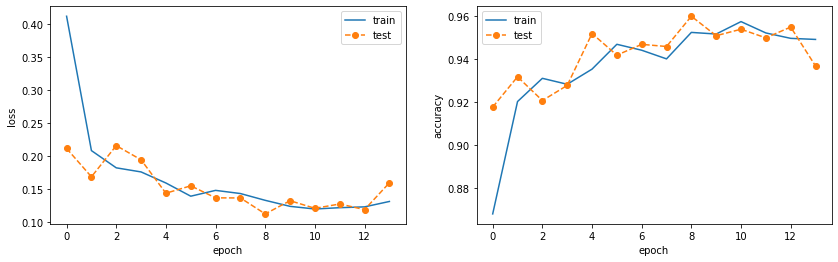

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Probando el modelo

VGG16
1/1 [==============================] - 1s 813ms/step


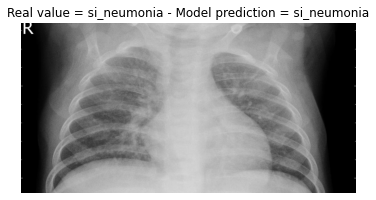

1/1 [==============================] - 0s 18ms/step


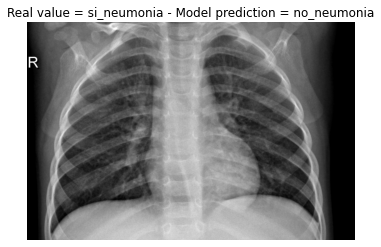

1/1 [==============================] - 0s 20ms/step


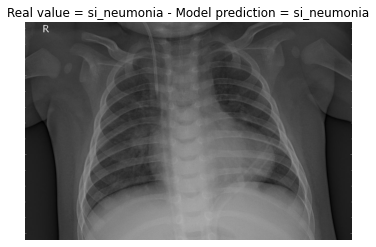

1/1 [==============================] - 0s 16ms/step


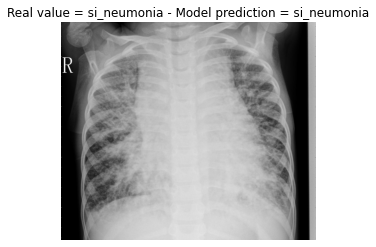

1/1 [==============================] - 0s 17ms/step


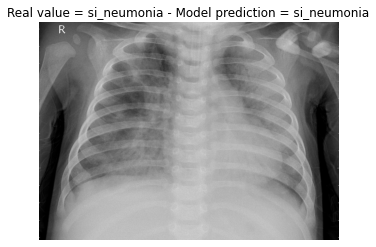

1/1 [==============================] - 0s 15ms/step


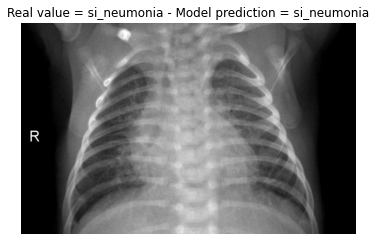

1/1 [==============================] - 0s 17ms/step


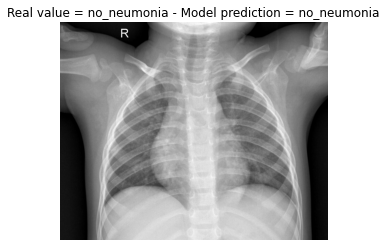

1/1 [==============================] - 0s 17ms/step


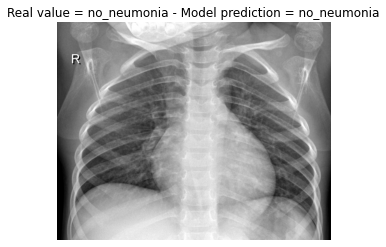

1/1 [==============================] - 0s 19ms/step


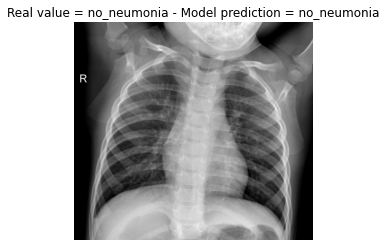

1/1 [==============================] - 0s 16ms/step


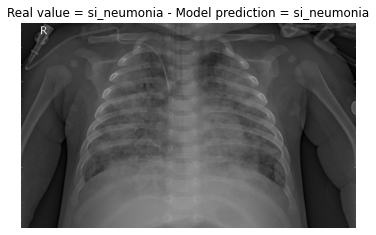

In [ ]:
print(applications)
labels_dict = {k: i for i, k in validation_generator.class_indices.items()}

number_of_images_to_test = 10

for _ in range(number_of_images_to_test):
  random_image_path = choice(validation_generator.filenames)
  
  get_class(images_train, random_image_path, labels_dict, final_model, applications)

### Fine tuning

In [ ]:
# Descongelar las capas de extracción de características
base_model.trainable = True

In [ ]:
# Veamos cuántas capas hay en el modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune a partir de estas capas
fine_tune_at = 10

# Congelar todas las capas más inferiores en este caso desde la 0:100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  20


In [ ]:
#Como está entrenando un modelo mucho más grande y quiere readaptar los pesos preentrenados,
#  es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, el modelo podría sobreajustarse muy rápidamente.

final_model.compile(optimizer=Adam(0.0001/10), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

len(final_model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 sequential (Sequential)     (None, 2)                 65922     
                                                                 
Total params: 14,780,610
Trainable params: 13,045,122
Non-trainable params: 1,735,488
_________________________________________________________________


16

In [ ]:
# Continúe entrenando el modelo
# Si ha entrenado antes hasta la convergencia, este paso mejorará su precisión en algunos puntos porcentuales.

# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      initial_epoch=log.epoch[-5],
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 10/100
63/63 [==============================] - 112s 2s/step - loss: 0.1205 - accuracy: 0.9548 - val_loss: 0.1084 - val_accuracy: 0.9668
Epoch 11/100
63/63 [==============================] - 107s 2s/step - loss: 0.1124 - accuracy: 0.9578 - val_loss: 0.1412 - val_accuracy: 0.9487
Epoch 12/100
63/63 [==============================] - 106s 2s/step - loss: 0.0916 - accuracy: 0.9666 - val_loss: 0.1054 - val_accuracy: 0.9608
Epoch 13/100
63/63 [==============================] - 109s 2s/step - loss: 0.0818 - accuracy: 0.9701 - val_loss: 0.0993 - val_accuracy: 0.9648
Epoch 14/100
63/63 [==============================] - 108s 2s/step - loss: 0.0690 - accuracy: 0.9734 - val_loss: 0.0793 - val_accuracy: 0.9759
Epoch 15/100
63/63 [==============================] - 107s 2s/step - loss: 0.0702 - accuracy: 0.9689 - val_loss: 0.1153 - val_accuracy: 0.9568
Epoch 16/100
63/63 [==============================] - 107s 2s/step - loss: 0.0643 - accuracy: 0.9771 - val_loss: 0.0783 - val_accuracy: 0.9769

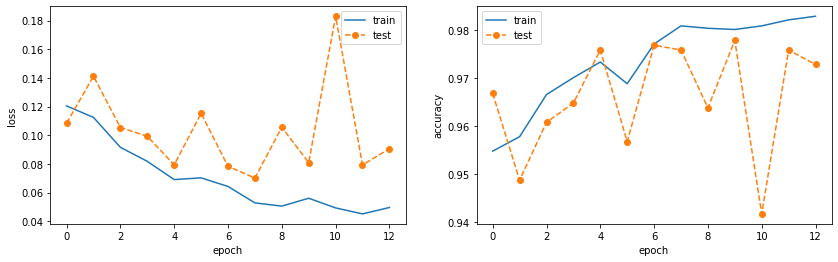

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Predecir en data de validación

In [ ]:
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
print(applications)
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
path_model = 'working2/best_{}.hdf5'.format(applications)
dataset= validation_generator
df_val = predict_new_dataset(path_model, dataset, applications, subset = 'valid')
df_val.shape

VGG16
16/16 [==============================] - 23s 1s/step


(995, 2)

In [ ]:
# Punto de corte para predecir 0 ó 1 y ver otras métricas
cut_point = df_val.Predictions.mean()
print(1-cut_point)
# Crear columna con predicción
df_val['pred'] = np.where(df_val.Predictions>1-cut_point,1,0)
df_val.head()

0.27028584480285645


,Filename,Predictions,pred
0,no_neumonia/004f7319-a006-5476-bba3-5a12c8a0f0...,0.002667,0
1,no_neumonia/00880387-7447-5ec2-a87d-deb294cfb3...,0.001033,0
2,no_neumonia/00af7693-5b69-528a-8e2b-bd99fed024...,0.001203,0
3,no_neumonia/00b1ea4d-3701-5eb9-928b-e22545be06...,0.006797,0
4,no_neumonia/00e2b542-2920-5728-bcd8-d16cf45a22...,0.003051,0


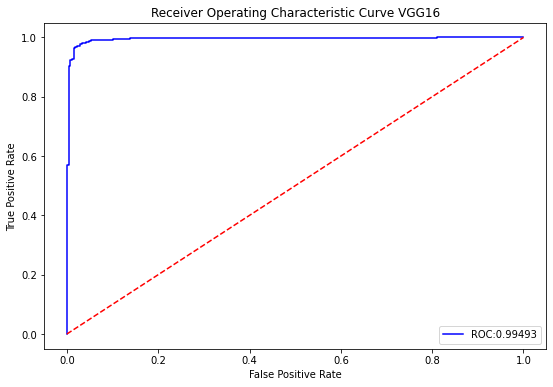

In [ ]:
# Plotear curva roc
auc = roc_auc_score (validation_generator.labels, df_val.Predictions) 
fper, tper, thresholds = roc_curve(validation_generator.labels, df_val.Predictions)
plot_roc_curve(fper, tper, auc, applications)


In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95       269
           1       0.98      0.99      0.98       726

    accuracy                           0.98       995
   macro avg       0.98      0.96      0.97       995
weighted avg       0.98      0.98      0.98       995



In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       269
           1       0.96      0.99      0.97       726

    accuracy                           0.96       995
   macro avg       0.96      0.94      0.95       995
weighted avg       0.96      0.96      0.96       995



Total de pacientes:  995


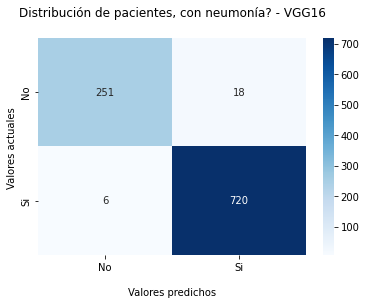

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

Total de pacientes:  995


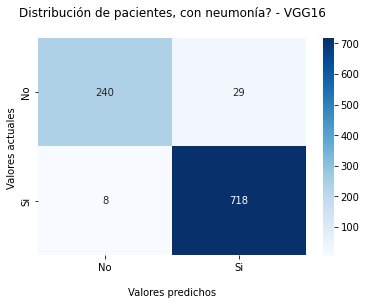

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

### Predecir data de test


In [ ]:
print(applications)
path_model = 'working2/best_{}.hdf5'.format(applications)
print(path_model)
dataset= 'images/test'
#predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1 = predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1.head()


VGG16
working2/best_VGG16.hdf5
Found 879 images belonging to 1 classes.
879/879 [==============================] - 19s 22ms/step


,Filename,Predictions
0,test_images/00182334-9ad9-516c-b0e4-10a316c61e...,0.999949
1,test_images/005030d9-7ee8-5082-ad72-1d9929d06e...,0.984546
2,test_images/00a0a69c-f14c-5f11-85ca-0f2e6729c3...,0.997578
3,test_images/00e84c18-3a08-59a8-9e3b-ed706c01e8...,0.005080
4,test_images/0158ac33-e4b2-5cd4-85de-0655c23cb9...,0.998582


In [ ]:
# Generar data y editar para envío
print(applications)
df_submission = edit_submission_data(submission1, applications)
df_submission.head()

VGG16
VGG16
(879, 3) (879, 2)
Total de valores nulos:  0


,Id,Predicted
90,0,0.999167
698,1,0.997785
399,2,0.000810
422,3,0.999992
305,4,0.999984


### 2.4. VGG19

In [ ]:
%%time
# Generar dataset de entrenamiento y validación.
applications = 'VGG19'
train_generator, validation_generator, target_train, target_valid = images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed)

Found 3982 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
CPU times: user 320 ms, sys: 29.8 ms, total: 350 ms
Wall time: 26.1 s


In [ ]:
target_train, target_valid

(array([0.27021597, 0.72978403]), array([0.27035176, 0.72964824]))

In [ ]:
### Balanceo.
#initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
#initial_bias
COUNT_PNEUMONIA = np.bincount(train_generator.labels)[1]
COUNT_NORMAL = np.bincount(train_generator.labels)[0]

In [ ]:
# Corregir desbalanceo
initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
initial_bias

array([0.9935271])

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(len(train_generator.labels))/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(len(train_generator.labels))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


In [ ]:
# Modelo base ResNet, para extracción de características
base_model = VGG19(include_top=False, # Eliminar las últimas capas densas de ResNet y quedarse solamente con las capas de feature extraction
                      input_shape=(img_size, img_size, 3), # Configurada para imágen a colores
                      pooling="avg")
base_model.trainable = False
base_model.summary()

80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# Modelo para la predicción de clases - customizado - fine tuning?
model = Sequential()
model.add(Dense(256, input_shape=(512,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 147,906
Trainable params: 147,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Conectamos la extracción de características mediante ResNet y la nuestra red densa
final_model = Sequential()
final_model.add(base_model)
final_model.add(model)

final_model.compile(optimizer=Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 sequential (Sequential)     (None, 2)                 147906    
                                                                 
Total params: 20,172,290
Trainable params: 147,906
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
if 'working2' not in os.listdir():
    os.mkdir('working2')

# Early stopping & checkpointing the best model in ../working2 dir & restoring that as our model for prediction
print(applications)
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = 'working2/best_{}.hdf5'.format(applications), monitor = 'val_loss', save_best_only = True, mode = 'auto')



VGG19


In [ ]:
%%time
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      callbacks=[cb_checkpointer, cb_early_stopper],
                      class_weight=class_weight)

Epoch 1/100
125/125 [==============================] - 441s 3s/step - loss: 0.7486 - accuracy: 0.7248 - val_loss: 0.2582 - val_accuracy: 0.9025
Epoch 2/100
125/125 [==============================] - 112s 899ms/step - loss: 0.3529 - accuracy: 0.8599 - val_loss: 0.2396 - val_accuracy: 0.9186
Epoch 3/100
125/125 [==============================] - 111s 892ms/step - loss: 0.2941 - accuracy: 0.8772 - val_loss: 0.2021 - val_accuracy: 0.9236
Epoch 4/100
125/125 [==============================] - 110s 881ms/step - loss: 0.2671 - accuracy: 0.8933 - val_loss: 0.2153 - val_accuracy: 0.9186
Epoch 5/100
125/125 [==============================] - 109s 869ms/step - loss: 0.2560 - accuracy: 0.8975 - val_loss: 0.1739 - val_accuracy: 0.9286
Epoch 6/100
125/125 [==============================] - 109s 868ms/step - loss: 0.2236 - accuracy: 0.9141 - val_loss: 0.1997 - val_accuracy: 0.9276
Epoch 7/100
125/125 [==============================] - 109s 870ms/step - loss: 0.2256 - accuracy: 0.9131 - val_loss: 0.19

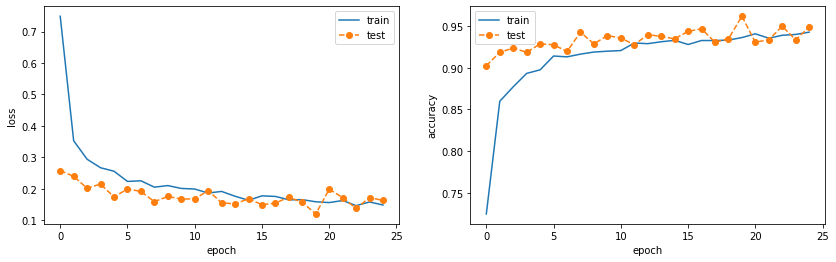

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Probando el modelo

VGG19
1/1 [==============================] - 1s 853ms/step


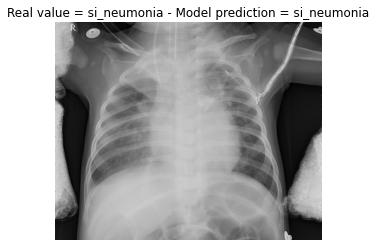

1/1 [==============================] - 0s 19ms/step


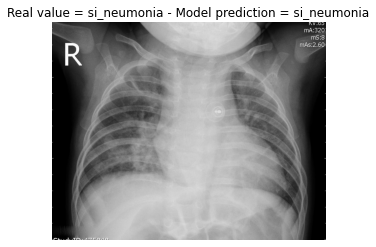

1/1 [==============================] - 0s 18ms/step


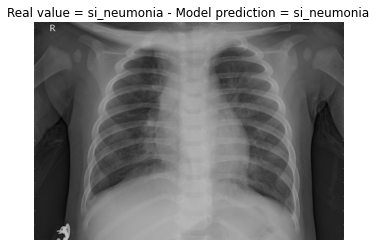

1/1 [==============================] - 0s 22ms/step


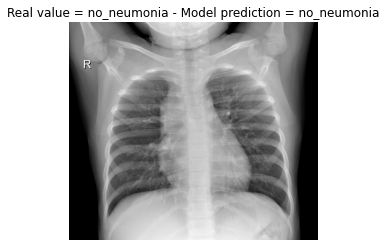

1/1 [==============================] - 0s 19ms/step


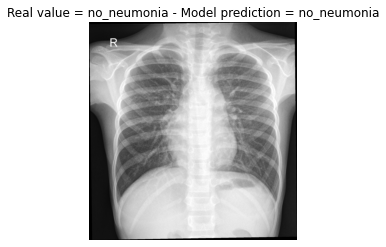

1/1 [==============================] - 0s 17ms/step


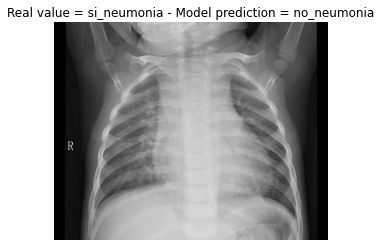

1/1 [==============================] - 0s 17ms/step


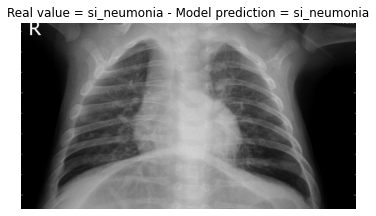

1/1 [==============================] - 0s 26ms/step


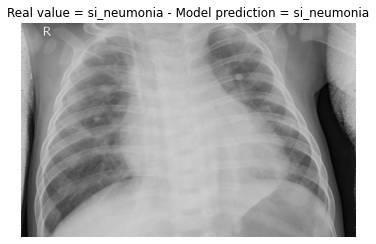

1/1 [==============================] - 0s 22ms/step


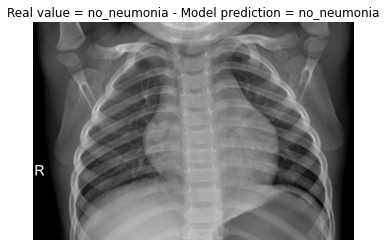

1/1 [==============================] - 0s 25ms/step


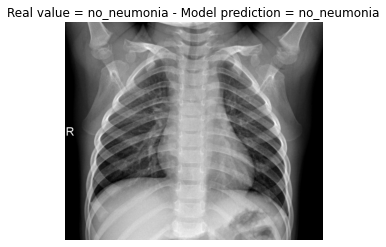

In [ ]:
print(applications)
labels_dict = {k: i for i, k in validation_generator.class_indices.items()}

number_of_images_to_test = 10

for _ in range(number_of_images_to_test):
  random_image_path = choice(validation_generator.filenames)
  
  get_class(images_train, random_image_path, labels_dict, final_model, applications)

### Fine tuning

In [ ]:
# Descongelar las capas de extracción de características
base_model.trainable = True


# Veamos cuántas capas hay en el modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune a partir de estas capas
fine_tune_at = 10

Number of layers in the base model:  23


In [ ]:
# Congelar todas las capas más inferiores en este caso desde la 0:100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

#Como está entrenando un modelo mucho más grande y quiere readaptar los pesos preentrenados,
#  es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, el modelo podría sobreajustarse muy rápidamente.

final_model.compile(optimizer=Adam(0.0001/10), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

len(final_model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 sequential (Sequential)     (None, 2)                 147906    
                                                                 
Total params: 20,172,290
Trainable params: 18,436,802
Non-trainable params: 1,735,488
_________________________________________________________________


24

In [ ]:
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      initial_epoch=log.epoch[-5],
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 21/100
125/125 [==============================] - 127s 975ms/step - loss: 0.1566 - accuracy: 0.9415 - val_loss: 0.1075 - val_accuracy: 0.9698
Epoch 22/100
125/125 [==============================] - 124s 989ms/step - loss: 0.1308 - accuracy: 0.9533 - val_loss: 0.0921 - val_accuracy: 0.9678
Epoch 23/100
125/125 [==============================] - 121s 971ms/step - loss: 0.1084 - accuracy: 0.9591 - val_loss: 0.0879 - val_accuracy: 0.9658
Epoch 24/100
125/125 [==============================] - 120s 961ms/step - loss: 0.0944 - accuracy: 0.9661 - val_loss: 0.0815 - val_accuracy: 0.9719
Epoch 25/100
125/125 [==============================] - 113s 906ms/step - loss: 0.0819 - accuracy: 0.9711 - val_loss: 0.0701 - val_accuracy: 0.9779
Epoch 26/100
125/125 [==============================] - 112s 896ms/step - loss: 0.0708 - accuracy: 0.9724 - val_loss: 0.0733 - val_accuracy: 0.9779
Epoch 27/100
125/125 [==============================] - 111s 886ms/step - loss: 0.0702 - accuracy: 0.9749 - val_

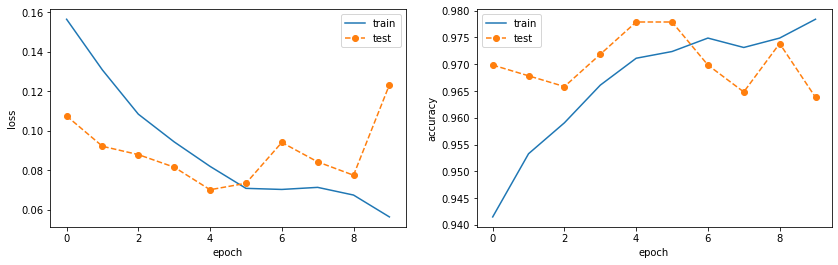

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Predecir en data de validación

In [ ]:
print(applications)
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
path_model = 'working2/best_{}.hdf5'.format(applications)
dataset= validation_generator
df_val = predict_new_dataset(path_model, dataset, applications, subset = 'valid')
df_val.shape

VGG19
32/32 [==============================] - 23s 695ms/step


(995, 2)

In [ ]:
# Punto de corte para predecir 0 ó 1 y ver otras métricas
cut_point = df_val.Predictions.mean()
print(1-cut_point)
# Crear columna con predicción
df_val['pred'] = np.where(df_val.Predictions>1-cut_point,1,0)
df_val.head()

0.2703101634979248


,Filename,Predictions,pred
0,no_neumonia/004f7319-a006-5476-bba3-5a12c8a0f0...,0.005816,0
1,no_neumonia/00880387-7447-5ec2-a87d-deb294cfb3...,0.016354,0
2,no_neumonia/00af7693-5b69-528a-8e2b-bd99fed024...,0.000471,0
3,no_neumonia/00b1ea4d-3701-5eb9-928b-e22545be06...,0.000419,0
4,no_neumonia/00e2b542-2920-5728-bcd8-d16cf45a22...,0.000215,0


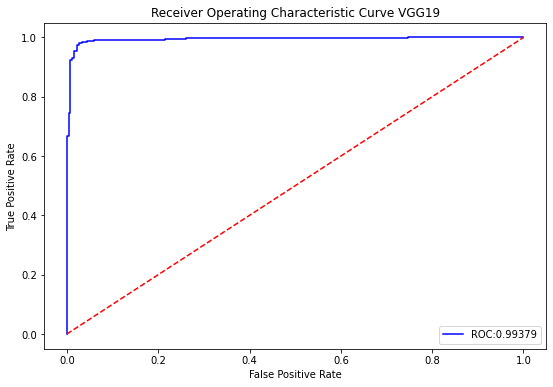

In [ ]:
# Plotear curva roc
auc = roc_auc_score (validation_generator.labels, df_val.Predictions) 
fper, tper, thresholds = roc_curve(validation_generator.labels, df_val.Predictions)
plot_roc_curve(fper, tper, auc, applications)

In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       269
           1       0.97      0.99      0.98       726

    accuracy                           0.97       995
   macro avg       0.97      0.96      0.97       995
weighted avg       0.97      0.97      0.97       995



Total de pacientes:  995


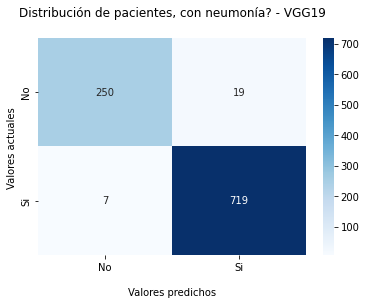

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

### Predecir data de test

In [ ]:
print(applications)
path_model = 'working2/best_{}.hdf5'.format(applications)
print(path_model)
dataset= 'images/test'
#predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1 = predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1.head()

VGG19
working2/best_VGG19.hdf5
Found 879 images belonging to 1 classes.
879/879 [==============================] - 23s 26ms/step


,Filename,Predictions
0,test_images/00182334-9ad9-516c-b0e4-10a316c61e...,0.999997
1,test_images/005030d9-7ee8-5082-ad72-1d9929d06e...,0.998867
2,test_images/00a0a69c-f14c-5f11-85ca-0f2e6729c3...,0.999949
3,test_images/00e84c18-3a08-59a8-9e3b-ed706c01e8...,0.003103
4,test_images/0158ac33-e4b2-5cd4-85de-0655c23cb9...,0.999960


In [ ]:
# Generar data y editar para envío
print(applications)
df_submission = edit_submission_data(submission1, applications)
df_submission.head()

VGG19
VGG19
(879, 3) (879, 2)
Total de valores nulos:  0


,Id,Predicted
90,0,0.989237
698,1,0.965665
399,2,0.001470
422,3,0.999464
305,4,0.999997


### 2.5. InceptionV3

In [ ]:
# Configurar parámetros
images_train = 'images/train' # Ruta con imágenes de entrenamiento
validation_split = 0.2 # 20% para el conjunto de validación y 80% para entrenamiento
img_size = 299  # Redimensionar la imágenes , dimensiones diferentres
batch_size = 32 # Tamaño de lote para entrenar
seed = 1 # Semilla aleatoria para reproducir los experimentos.

In [ ]:
%%time
# Generar dataset de entrenamiento y validación.
applications = 'InceptionV3'
train_generator, validation_generator, target_train, target_valid = images_datasets_generator(images_train, applications, validation_split, img_size, batch_size, seed)

Found 3982 images belonging to 2 classes.
Found 995 images belonging to 2 classes.
CPU times: user 316 ms, sys: 40.3 ms, total: 357 ms
Wall time: 24.3 s


In [ ]:
target_train, target_valid

(array([0.27021597, 0.72978403]), array([0.27035176, 0.72964824]))

In [ ]:
# Modelo base InceptionV3, para extracción de características
base_model = InceptionV3(include_top=False, # Eliminar las últimas capas densas de ResNet y quedarse solamente con las capas de feature extraction
                      input_shape=(img_size, img_size, 3), # Configurada para imágen a colores
                      pooling="avg")
base_model.trainable = False
base_model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [ ]:
# Modelo para la predicción de clases - customizado - fine tuning?
model = Sequential()
model.add(Dense(256, input_shape=(2048,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 541,122
Trainable params: 541,122
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Conectamos la extracción de características mediante ResNet y la nuestra red densa
final_model = Sequential()
final_model.add(base_model)
final_model.add(model)

final_model.compile(optimizer=Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 sequential (Sequential)     (None, 2)                 541122    
                                                                 
Total params: 22,343,906
Trainable params: 541,122
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
if 'working2' not in os.listdir():
    os.mkdir('working2')

# Early stopping & checkpointing the best model in ../working2 dir & restoring that as our model for prediction
print(applications)
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 5)
cb_checkpointer = ModelCheckpoint(filepath = 'working2/best_{}.hdf5'.format(applications), monitor = 'val_loss', save_best_only = True, mode = 'auto')



InceptionV3


Epoch 1/100
125/125 [==============================] - 1019s 8s/step - loss: 0.3503 - accuracy: 0.8481 - val_loss: 0.3159 - val_accuracy: 0.8513
Epoch 2/100
125/125 [==============================] - 146s 1s/step - loss: 0.2307 - accuracy: 0.9051 - val_loss: 0.2113 - val_accuracy: 0.9226
Epoch 3/100
125/125 [==============================] - 146s 1s/step - loss: 0.2037 - accuracy: 0.9206 - val_loss: 0.2044 - val_accuracy: 0.9246
Epoch 4/100
125/125 [==============================] - 145s 1s/step - loss: 0.2049 - accuracy: 0.9247 - val_loss: 0.1748 - val_accuracy: 0.9317
Epoch 5/100
125/125 [==============================] - 143s 1s/step - loss: 0.1944 - accuracy: 0.9211 - val_loss: 0.1871 - val_accuracy: 0.9256
Epoch 6/100
125/125 [==============================] - 146s 1s/step - loss: 0.1789 - accuracy: 0.9307 - val_loss: 0.1633 - val_accuracy: 0.9397
Epoch 7/100
125/125 [==============================] - 143s 1s/step - loss: 0.1811 - accuracy: 0.9302 - val_loss: 0.1666 - val_accuracy

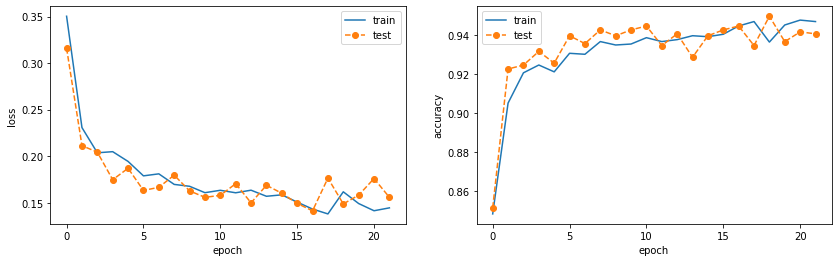

In [ ]:
%%time
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      callbacks=[cb_checkpointer, cb_early_stopper])

# Curvas de rendimiento del modelo
show_results(log)

### Fine tuning

In [ ]:
# Descongelar las capas de extracción de características
base_model.trainable = True

In [ ]:
# Veamos cuántas capas hay en el modelo base
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune a partir de estas capas
fine_tune_at = 250

# Congelar todas las capas más inferiores en este caso desde la 0:100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  312


In [ ]:
#Como está entrenando un modelo mucho más grande y quiere readaptar los pesos preentrenados,
#  es importante utilizar una tasa de aprendizaje más baja en esta etapa. De lo contrario, el modelo podría sobreajustarse muy rápidamente.

final_model.compile(optimizer=Adam(0.0001/10), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
final_model.summary()

len(final_model.trainable_variables)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 sequential (Sequential)     (None, 2)                 541122    
                                                                 
Total params: 22,343,906
Trainable params: 11,082,562
Non-trainable params: 11,261,344
_________________________________________________________________


41

In [ ]:
# Entrenar el modelo.
log = final_model.fit(train_generator, 
                      validation_data=validation_generator, 
                      epochs=100,
                      initial_epoch=log.epoch[-5],
                      callbacks=[cb_checkpointer, cb_early_stopper])

Epoch 18/100
125/125 [==============================] - 153s 1s/step - loss: 0.1687 - accuracy: 0.9377 - val_loss: 0.1501 - val_accuracy: 0.9427
Epoch 19/100
125/125 [==============================] - 144s 1s/step - loss: 0.1440 - accuracy: 0.9473 - val_loss: 0.1436 - val_accuracy: 0.9407
Epoch 20/100
125/125 [==============================] - 158s 1s/step - loss: 0.1325 - accuracy: 0.9503 - val_loss: 0.1082 - val_accuracy: 0.9618
Epoch 21/100
125/125 [==============================] - 146s 1s/step - loss: 0.1176 - accuracy: 0.9578 - val_loss: 0.1094 - val_accuracy: 0.9598
Epoch 22/100
125/125 [==============================] - 143s 1s/step - loss: 0.1203 - accuracy: 0.9558 - val_loss: 0.1204 - val_accuracy: 0.9558
Epoch 23/100
125/125 [==============================] - 143s 1s/step - loss: 0.1030 - accuracy: 0.9631 - val_loss: 0.1170 - val_accuracy: 0.9568
Epoch 24/100
125/125 [==============================] - 145s 1s/step - loss: 0.1074 - accuracy: 0.9613 - val_loss: 0.0982 - val_ac

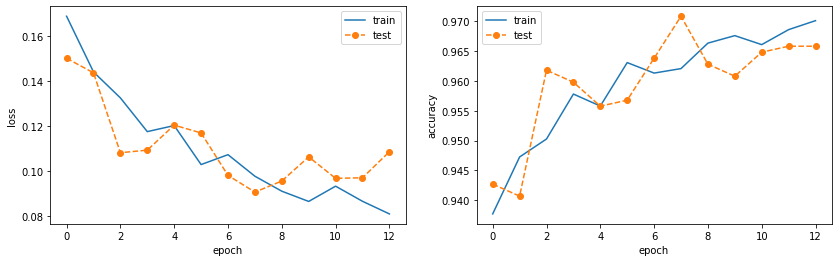

In [ ]:
# Curvas de rendimiento del modelo
show_results(log)

### Probando el modelo

### Predecir en data de validación

In [ ]:
print(applications)
# Prediccion en el dataset de validación para ver otras métricas de rendimiento
path_model = 'working2/best_{}.hdf5'.format(applications)
dataset= validation_generator
df_val = predict_new_dataset(path_model, dataset, applications, subset = 'valid')
df_val.shape

InceptionV3
32/32 [==============================] - 29s 873ms/step


(995, 2)

In [ ]:
# Punto de corte para predecir 0 ó 1 y ver otras métricas
cut_point = df_val.Predictions.mean()
print(1-cut_point)
# Crear columna con predicción
df_val['pred'] = np.where(df_val.Predictions>1-cut_point,1,0)
df_val.head()

0.26471495628356934


,Filename,Predictions,pred
0,no_neumonia/004f7319-a006-5476-bba3-5a12c8a0f0...,0.028682,0
1,no_neumonia/00880387-7447-5ec2-a87d-deb294cfb3...,0.914412,1
2,no_neumonia/00af7693-5b69-528a-8e2b-bd99fed024...,0.055534,0
3,no_neumonia/00b1ea4d-3701-5eb9-928b-e22545be06...,0.093470,0
4,no_neumonia/00e2b542-2920-5728-bcd8-d16cf45a22...,0.073670,0


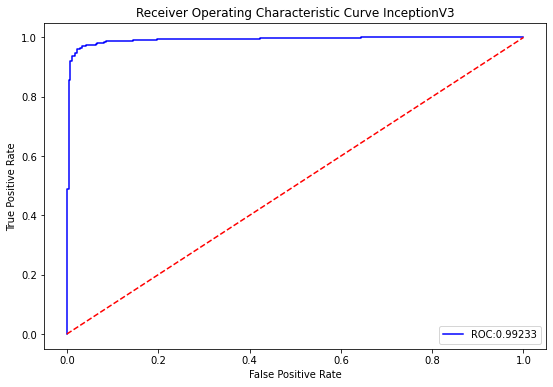

In [ ]:
# Plotear curva roc
auc = roc_auc_score (validation_generator.labels, df_val.Predictions) 
fper, tper, thresholds = roc_curve(validation_generator.labels, df_val.Predictions)
plot_roc_curve(fper, tper, auc, applications)

In [ ]:
# Otras métricas de rendimiento
print(classification_report(validation_generator.labels, df_val.pred))

              precision    recall  f1-score   support

           0       0.97      0.86      0.91       269
           1       0.95      0.99      0.97       726

    accuracy                           0.95       995
   macro avg       0.96      0.93      0.94       995
weighted avg       0.96      0.95      0.95       995



Total de pacientes:  995


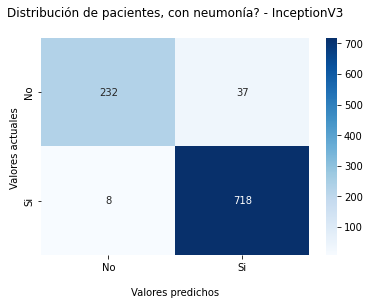

In [ ]:
# Matriz de confusión
plot_matriz_confusion(dataset, df_val, applications)

### Predecir data de test

In [ ]:
print(applications)
path_model = 'working2/best_{}.hdf5'.format(applications)
print(path_model)
dataset= 'images/test'
#predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1 = predict_new_dataset(path_model, dataset, applications, subset = 'test')
submission1.head()


InceptionV3
working2/best_InceptionV3.hdf5
Found 879 images belonging to 1 classes.
879/879 [==============================] - 34s 36ms/step


,Filename,Predictions
0,test_images/00182334-9ad9-516c-b0e4-10a316c61e...,0.999006
1,test_images/005030d9-7ee8-5082-ad72-1d9929d06e...,0.929152
2,test_images/00a0a69c-f14c-5f11-85ca-0f2e6729c3...,0.251461
3,test_images/00e84c18-3a08-59a8-9e3b-ed706c01e8...,0.000118
4,test_images/0158ac33-e4b2-5cd4-85de-0655c23cb9...,0.996701


In [ ]:
# Generar data y editar para envío
print(applications)
df_submission = edit_submission_data(submission1, applications)
df_submission.head()

InceptionV3
InceptionV3
(879, 3) (879, 2)
Total de valores nulos:  0


,Id,Predicted
90,0,0.970376
698,1,0.547629
399,2,0.664978
422,3,0.988958
305,4,0.997915
